<a href="https://colab.research.google.com/github/Nancy-Shi/ICE_Manuscript/blob/main/120523_block_superspreader_vs_no_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 3-Layer Model with Informtion, Behavior, Disease

In [1]:
#!pip uninstall -y numpy
#!pip uninstall -y setuptools
#!pip install setuptools
#!pip install numpy

In [2]:
#!pip install numpy --upgrade
#!pip install panda --upgrade

In [3]:
#!pip install hypernetx

In [4]:
import hypernetx as hnx

 No module named 'igraph'. If you need to use hypernetx.algorithms.hypergraph_modularity, please install additional packages by running the following command: pip install .['all']


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import math as math
from math import log
import seaborn as sns
import pandas as pd
import matplotlib.ticker as ticker

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



## Part 1: Hypergraph Generation
The following steps generate a hyper graph using the XGI/HyperNetX python package,  following power-law degree distribution for predifined number of nodes n, number of hyperedges num_hyper_edges, degree exponent gamma, using a configuration model with data stored in a dictionary.

In [6]:
# Step 1: Generate Degree Sequence
def generate_degree_sequence(n, gamma, kmin):
    # Generate a random set from the power law distribution
    u = np.random.uniform(size=n)
    degrees = np.ceil((1.0 - u) ** (-1.0 / (gamma - 1.0)))

    # Adjust degrees based on the minimum and maximum degree values
    kmax = int(np.sqrt(n))
    #kmax = int(((gamma-1)/(gamma-2) * n )** (1/gamma))  # max degree
    # kmax = int(1.5*n**(1/4)) # max degree allowed is 1.5*n^(1/4)
    degrees = degrees[(degrees >= kmin) & (degrees <= kmax)].astype(int)

    # Truncate or pad the sequence to match the length specified
    if len(degrees) >= n:
        degrees = degrees[:n]
    else:
        degrees = np.concatenate((degrees, np.full(n - len(degrees), kmin)))

    return degrees.tolist()

# Step 2: Generate Hyper Edge Size Sequence
def generate_hyper_edge_sizes(degrees, num_hyper_edges):
    total_degrees = sum(degrees)
    hyper_edge_sizes = []

    # Calculate the average size for each hyper edge
    avg_size = total_degrees // num_hyper_edges
    remainder = total_degrees % num_hyper_edges

    # Define the range for the random distribution
    min_size = 2  # Lower bound of the range
    max_size = int(np.sqrt(total_degrees))  # Upper bound of the range
    #max_size = len(degrees) - num_hyper_edges  # Upper bound of the range

    # Generate hyper edge sizes
    for _ in range(num_hyper_edges):
        size = random.randint(min_size, max_size)
        hyper_edge_sizes.append(size)

    return hyper_edge_sizes


# Step 3: Create Copies of Nodes
def create_node_copies(degrees):
    node_copies = []
    for i, degree in enumerate(degrees):
        for _ in range(degree):
            node_copies.append(i)
    return node_copies

# Step 4: Create Copies of Hyper Edges
def create_hyper_edge_copies(hyper_edge_sizes):
    hyper_edge_copies = []
    for i, size in enumerate(hyper_edge_sizes):
        for _ in range(size):
            hyper_edge_copies.append(i)
    return hyper_edge_copies

# Step 5: Randomly Pair Copies without Repeated Pairs
def randomly_pair_copies(node_copies, hyper_edge_copies):
    pairs = []
    paired_hyper_edges = {} # Using a dictionary to track paired hyper-edges with nodes

    for node_copy in node_copies:
        available_hyper_edges = [h for h in hyper_edge_copies if (h, node_copy) not in paired_hyper_edges]

        # If no available hyper-edges left, shuffle the paired hyper-edges and reset
        if not available_hyper_edges:
            paired_hyper_edges = {}
            available_hyper_edges = [h for h in hyper_edge_copies if (h, node_copy) not in paired_hyper_edges]

        # Randomly choose a hyper-edge that has not been paired yet with the current node
        chosen_hyper_edge = random.choice(available_hyper_edges)
        pairs.append((node_copy, chosen_hyper_edge))

        # Add to paired_hyper_edges
        paired_hyper_edges[(chosen_hyper_edge, node_copy)] = True
        hyper_edge_copies.remove(chosen_hyper_edge)

    return pairs

# Step 6: Convert Bipartite Graph to A Hypergraph Dictionary
def convert_to_hypergraph(pairs):
    hypergraph = {}
    for pair in pairs:
        node, hyper_edge = pair
        if hyper_edge in hypergraph:
            hypergraph[hyper_edge].append(node)
        else:
            hypergraph[hyper_edge] = [node]
    return hypergraph


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
def build_hypergraph(n, gamma, kmin, num_hyper_edges):
    # Step 1: Generate Degree Sequence
    degrees = generate_degree_sequence(n, gamma, kmin)
    print("Degree Sequence: ", degrees)

    # Step 2: Generate Hyper Edge Size Sequence
    hyper_edge_sizes = generate_hyper_edge_sizes(degrees, num_hyper_edges)
    print("Hyper Edge Sizes: ", hyper_edge_sizes)

    # Step 3: Create Copies of Nodes
    node_copies = create_node_copies(degrees)

    # Step 4: Create Copies of Hyper Edges
    hyper_edge_copies = create_hyper_edge_copies(hyper_edge_sizes)

    # Step 5: Randomly Pair Copies
    pairs = randomly_pair_copies(node_copies, hyper_edge_copies)

    # Step 6: Convert Bipartite Graph to Hypergraph
    hyperedge_dict = convert_to_hypergraph(pairs)

    # Print the resulting hypergraph
    print("Hypergraph Dictionary: ", hyperedge_dict)

    return degrees, hyperedge_dict

In [8]:
# Test 2
n2 = 500  # Number of nodes
gamma2 = 2.5  # Power-law exponent
kmin2 = 3  # Minimum degree
num_hyper_edges2 = 100  # Desired number of hyper edges

degrees2, hyperedge_dict2 = build_hypergraph(n2, gamma2, kmin2, num_hyper_edges2)
H2 = hnx.Hypergraph(hyperedge_dict2)

Degree Sequence:  [5, 3, 12, 4, 4, 4, 3, 14, 4, 3, 4, 5, 3, 5, 4, 3, 3, 5, 3, 5, 3, 17, 5, 3, 5, 4, 21, 5, 3, 3, 3, 4, 3, 3, 4, 6, 6, 5, 8, 3, 3, 4, 6, 4, 17, 4, 3, 4, 7, 3, 3, 5, 7, 4, 3, 4, 5, 4, 3, 3, 11, 4, 8, 6, 3, 6, 8, 3, 5, 4, 6, 3, 3, 3, 5, 5, 3, 3, 3, 5, 3, 7, 3, 3, 4, 10, 5, 3, 3, 8, 3, 3, 3, 3, 3, 3, 6, 6, 4, 3, 6, 15, 6, 5, 3, 3, 3, 4, 3, 3, 4, 5, 4, 3, 6, 3, 4, 5, 5, 4, 3, 3, 10, 8, 4, 5, 3, 4, 4, 15, 8, 5, 18, 3, 4, 4, 3, 5, 5, 4, 3, 5, 3, 8, 3, 5, 5, 6, 7, 3, 5, 8, 3, 3, 9, 3, 7, 4, 7, 3, 8, 5, 3, 3, 4, 3, 3, 3, 9, 3, 3, 4, 3, 6, 4, 11, 3, 5, 8, 3, 3, 12, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


## Part 2: Assign Behavior Status
NP represents the state of no protection, while P represents the state of with protection.

In [9]:
def assign_protection(hypergraph, fraction_protected):
    # Get the list of nodes from the hypergraph
    nodes = list(hypergraph.nodes())

    # Calculate the number of nodes to protect
    num_nodes_to_protect = int(len(nodes) * fraction_protected)

    # Randomly choose nodes to protect
    nodes_to_protect = random.sample(nodes, num_nodes_to_protect)

    # Initialize the protection status dictionary
    protection_status = {}

    # Assign protection status to each node
    for node in nodes:
        if node in nodes_to_protect:
            protection_status[node] = "P"  # Protected node
        else:
            protection_status[node] = "N"  # Non-protected node

    print(protection_status)

    return protection_status

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
# Test:
fraction_protected = 0.1  # 40% of nodes will be protected
protection_status_dict = assign_protection(H2, fraction_protected)
print(protection_status_dict)

{0: 'N', 1: 'N', 2: 'N', 3: 'N', 4: 'N', 5: 'N', 6: 'N', 7: 'N', 8: 'N', 9: 'N', 10: 'N', 11: 'N', 12: 'N', 13: 'P', 14: 'N', 15: 'N', 16: 'N', 17: 'N', 18: 'P', 19: 'N', 20: 'N', 21: 'N', 22: 'N', 23: 'P', 24: 'N', 25: 'N', 26: 'N', 27: 'N', 28: 'N', 29: 'N', 30: 'N', 31: 'N', 32: 'N', 33: 'N', 34: 'N', 35: 'N', 36: 'N', 37: 'N', 38: 'N', 39: 'N', 40: 'N', 41: 'N', 42: 'N', 43: 'N', 44: 'N', 45: 'N', 46: 'N', 47: 'N', 48: 'N', 49: 'N', 50: 'N', 51: 'N', 52: 'N', 53: 'N', 54: 'N', 55: 'N', 56: 'N', 57: 'N', 58: 'N', 59: 'N', 60: 'N', 61: 'N', 62: 'N', 63: 'P', 64: 'N', 65: 'N', 66: 'N', 67: 'N', 68: 'N', 69: 'N', 70: 'N', 71: 'N', 72: 'N', 73: 'N', 74: 'N', 75: 'P', 76: 'N', 77: 'N', 78: 'N', 79: 'N', 80: 'N', 81: 'N', 82: 'P', 83: 'N', 84: 'N', 85: 'N', 86: 'N', 87: 'N', 88: 'N', 89: 'P', 90: 'N', 91: 'N', 92: 'N', 93: 'N', 94: 'N', 95: 'N', 96: 'P', 97: 'N', 98: 'N', 99: 'N', 100: 'N', 101: 'N', 102: 'N', 103: 'N', 104: 'N', 105: 'P', 106: 'N', 107: 'N', 108: 'N', 109: 'P', 110: 'N',


## Part 3: Assign Threshold
The following steps assigns a threshold value to each node in the network. The threshold follows a uniform or normal distribution with predefined mean (mu) and standard deviation (sigma).

In [11]:
# Defines the parameters to be used
mu = 0.1
sigma = 0.05

# Function to assign thresholds to the individual nodes
def assign_thresholds(hypergraph, mu, sigma):
    NV = hypergraph.order()
    Ltre = {}

    for node in hypergraph.nodes():
          # Uniform distribution: #
          #Ltre[node] = np.random.uniform()
          # Normal distrution
          while True:
              threshold = random.gauss(mu, sigma)
              if 0 < threshold < 1:
                  break
          Ltre[node] = threshold

    return Ltre

In [12]:
Ltre2 = assign_thresholds(H2, mu, sigma)

print("Threshold List for Nodes: ", Ltre2 )

Threshold List for Nodes:  {0: 0.08761079585775143, 1: 0.11940935120723137, 2: 0.04249050528182231, 3: 0.168149220399121, 4: 0.11170786318924467, 5: 0.06735107675309435, 6: 0.0002474201009981247, 7: 0.0717586025022761, 8: 0.09671265530488231, 9: 0.04864169503259644, 10: 0.18033609127669076, 11: 0.12228495519518247, 12: 0.158166962652265, 13: 0.17662393424662962, 14: 0.11039846763038236, 15: 0.0951934624897193, 16: 0.08422123034988388, 17: 0.13034626296969062, 18: 0.10650239807219088, 19: 0.13381505126465568, 20: 0.1197022645296473, 21: 0.1358452771447595, 22: 0.17859051986325167, 23: 0.06661839814696519, 24: 0.08036121400686448, 25: 0.16510360929542195, 26: 0.0018965256896205235, 27: 0.14881403483351197, 28: 0.0911784267667159, 29: 0.13178044221543858, 30: 0.106366122507854, 31: 0.04869617315876157, 32: 0.07762432747976528, 33: 0.09279135034000988, 34: 0.13238685852851348, 35: 0.12501624112245685, 36: 0.14090805026389425, 37: 0.09192755044999966, 38: 0.13639317606313042, 39: 0.07026612

# Part 4: The ICE Model (The Information Cognition Epidemics Model)
## Information Layer
The misinformation spread occurs on a hyperedge network involving group spreading. The three stages are U(unaware), G(gossip/spreader), and C(stifler/corrected).  

## Cognition Layer
In the cognitive behavioral layer, P is protected, and N is not protected. The rate of transition from state P to N, p, depends on the information layer. The rate from NP to P is 1-p. The transition rate of a node is also affected by the number of active spreader/stiflers. The bigger number of active neighbors, the faster the rate. Another way behavior may change is based on the fraction of protected neighbors.

## Epidemics Layer
In the epidemics layer, the possible disease states are S(susceptible), I(infected), and R(recovered). The illness spreading is pairwise. The disease propagation rate depends on the fraction of protected individuals $\rho_P$.



In [13]:
def ICE_model_no_control(inw, ldeg_i, ltre, cnw, ldeg_c, lprot, enw, ldeg_e, lam, alp, zeta_1, zeta_2, zeta_3, zeta_4, beta_PP, beta_NP, beta_PN, beta_NN, mu, n_sample):
  """
  Input:
      inw - information hyperedge network
      ltre - list of thresholds for informaiton spread
      ldeg_i - degree sequence of information layer

      cnw - cognitive network
      lprot - list of protection status
      ldeg_c - degree sequence of cognition layer

      enw - epidemic pairwise network
      ldeg_e - degree sequence of epidemic layer

      lambda - information spreading rate
      alp - informaiton stifling rate

      zeta_1 - removing protection rate based on information
      zeta_2 - removing protection rate based on neighborhood behavior
      zeta_1 - adopting protection rate based on information
      zeta_2 - adopting protection rate based on neighborhood behavior

      beta_PP - disease transmission rate between protected S and protected I
      beta_NP - disease transmission rate between not protected S and protected I
      beta_PN - disease transmission rate between protected S and not protected I
      beta_NN - disease transmission rate between not protected S and not protected I

      mu - disease recovery rate

      n_sample - number of samples
  """

  t_max = 1000      # Set maximum time
  kmax_i = max (ldeg_i)     # Get maximum hyperedge degree in information layer
  kmax_c = max (ldeg_c)     # Get maximum hyperedge degree in cognition layer
  kmax_e = max (ldeg_e)     # Get maximum degree in epidemic layer
  N = inw.order()  # Get the network size

  rho_C = []   # Keep track of fraction of corrected in information layer
  rho_P = []   # Keep track of fraction of protected in cognition layer
  rho_R = []   # Keep track of fraction of recovered in epidemic layer

  for i_samp in range(1, n_sample + 1):
      t = 0                 # Initialize time, number of corrected, number of recovered
      N_corrected = 0
      N_recovered = 0

      info_states = {j: "U" for j in inw.nodes()}   # Initialize information and disease states
      disease_states = {k: "S" for k in enw.nodes()}

      protected = list(filter(lambda node: lprot[node] == "P", lprot))
      N_protected = len(protected)
      not_protected = list(filter(lambda node: lprot[node] == "N", lprot))


      gossip = []     # Create lists to store gossip and corrected individuals in information layer
      corrected = []

      rumor_node_0 = np.random.choice(list(inw.nodes()))   # Pick a random person to start misinformaiton spreading
      info_states[rumor_node_0] = "G"
      gossip.append(rumor_node_0)
      N_gossip = 1
      N_e_i = inw.degree(rumor_node_0)

      infected = []     # Create lists to store infected and recovered individuals in epidemic layer
      recovered = []
      time_record= [0]
      prevalence_count = [0]
      recovered_count = [0]

      ill_node_0 = np.random.choice(list(enw.nodes()))   # Pick a random person to start disease spreading
      disease_states[ill_node_0] = "I"
      infected.append(ill_node_0)
      N_infected = 1
      N_e_e = enw.degree(ill_node_0)

      sum_of_beta = beta_PP + beta_NP + beta_PN + beta_NN

      while t < 150 and N_infected > 0:   # We stop when there is no infection
        total_rate = lam * N_e_i + 2 * alp * N_e_i + sum_of_beta * N_e_e + mu * N_infected + zeta_1 * N_protected + zeta_2 * (N-N_protected) + zeta_3 * N_protected + zeta_4 * (N-N_protected)
        tau = -np.log(np.random.uniform(1e-6, 1)) / total_rate
        t += tau

        if t >= t_max:
                break

      # Determine which event occurs
        event = np.random.uniform()
        p1 = (lam * N_e_i) / total_rate     # rumor spreading
        p2 = (lam * N_e_i + alp * N_e_i) / total_rate  # rumor stifling (by meeting stifling neighbor threshold)
        p3 = (lam * N_e_i + 2 * alp * N_e_i) / total_rate  # rumor stifling (by meeting gossip neighbor threshold)

        p4 = (lam * N_e_i + 2 * alp * N_e_i + sum_of_beta * N_e_e) / total_rate  # disease propagation
        p5 = (lam * N_e_i + 2 * alp * N_e_i + sum_of_beta * N_e_e + mu * N_infected) / total_rate  # disease recovery

        p6 = (lam * N_e_i + 2 * alp * N_e_i + sum_of_beta * N_e_e + mu * N_infected + zeta_1 * N_protected) / total_rate # change to not adopting protection by information
        p7 = (lam * N_e_i + 2 * alp * N_e_i + sum_of_beta * N_e_e + mu * N_infected + zeta_1 * N_protected + zeta_2 * (N-N_protected) ) / total_rate # change to adopting protection by information
        p8 = (lam * N_e_i + 2 * alp * N_e_i + sum_of_beta * N_e_e + mu * N_infected + zeta_1 * N_protected + zeta_2 * (N-N_protected)  + zeta_3 * N_protected) / total_rate # change to not adopting protection by neighborhood behavior
          # > p8 # change to adopting protection by neighborhood behavior
          #print(p1, p2, p3, p4, p5, p6, p7, p8)

          # Determine if accept selected individual based on degree distribution
        q_deg_i = np.random.uniform()
        q_deg_c = np.random.uniform()
        q_deg_e = np.random.uniform()

          # Case 1: Rumor spreading
        if event < p1:
                gossip_node = np.random.choice(gossip)
                if q_deg_i < inw.degree(gossip_node) / kmax_i:
                    edges_containing_gossip = [edge for edge in inw.edges() if gossip_node in inw[edge]]
                    if edges_containing_gossip:
                        rumor_hyper_edge = np.random.choice(edges_containing_gossip)
                        neighbors = inw[rumor_hyper_edge]
                        for neighbor in neighbors:
                            if info_states[neighbor] == "U":
                                count_gossip_neighbors = sum(1 for node in inw.neighbors(neighbor) if info_states[node] == "G")
                                if count_gossip_neighbors / len(inw.neighbors(neighbor)) >= ltre[neighbor]:
                                    info_states[neighbor] = "G"  # uninformed neighbor becomes gossip spreader
                                    gossip.append(neighbor)
                                    N_gossip += 1
                                    N_e_i += inw.degree(neighbor)

                    '''
                    rumor_hyper_edge = np.random.choice(list(inw.edges()))
                    neighbors = inw[rumor_hyper_edge]

                    MAX_ITERATIONS = 100
                    iterations = 0
                    while gossip_node not in neighbors:
                        if iterations > MAX_ITERATIONS:
                           break
                        rumor_hyper_edge = np.random.choice(list(inw.edges()))
                        neighbors = inw[rumor_hyper_edge]
                        iterations += 1
                    '''

          # Case 2: Rumor stifling (by meeting stifling neighbor threshold)
        elif event < p2:
            #if N_gossip > 0:
                stifler_node = np.random.choice(gossip)
                if q_deg_i < inw.degree(stifler_node)  / kmax_i:
                    stifler_hyper_edge = np.random.choice(list(inw.edges()))
                    neighbors = inw[stifler_hyper_edge]
                    count_stifler_neighbors = sum(1 for node in inw.neighbors(stifler_node) if info_states[node] == "C")
                    if count_stifler_neighbors / len(neighbors) >= 0.3: # New rule #2 for recovery
                    #neighbor = np.random.choice(neighbors) # New rule for recovery
                    #if info_states[neighbor=="C"]:
                            info_states[stifler_node] = "C"
                            N_gossip -= 1
                            gossip.remove(stifler_node)
                            corrected.append(stifler_node)
                            N_corrected += 1
                            N_e_i -= inw.degree(stifler_node)

          # Case 3: Rumor stifling (by meeting gossip neighbor threshold)
        elif event < p3:
            #if N_gossip > 0:
                stifler_node = np.random.choice(gossip)
                if q_deg_i < inw.degree(stifler_node) / kmax_i:
                    stifler_hyper_edge = np.random.choice(list(inw.edges()))
                    neighbors = inw[stifler_hyper_edge]
                    count_gossip_neighbors = sum(1 for node in inw.neighbors(stifler_node) if info_states[node] == "G")
                    if count_gossip_neighbors / len(neighbors) >= 0.3: # New rule #2 for recovery
                    #neighbor = np.random.choice(neighbors) # New rule for recovery
                    #if info_states[neighbor=="G"]:
                            info_states[stifler_node] = "C"
                            N_gossip -= 1
                            gossip.remove(stifler_node)
                            corrected.append(stifler_node)
                            N_corrected += 1
                            N_e_i -= inw.degree(stifler_node)

          # Case 4: Disease propagation
        elif event < p4:
            draw_infection_event = np.random.uniform()
            # Infection event #1: between S_P and I_P
            if draw_infection_event < beta_PP/sum_of_beta:
                infected_protected = list(set(infected).intersection(protected))
                if len(infected_protected)>0:
                  infected_node = np.random.choice(infected_protected)
                  neighbors = list(enw.neighbors(infected_node))
                  susceptible_protected_neighbors = [node for node in neighbors if disease_states.get(node) == 'S' and node in protected]
                  if len(susceptible_protected_neighbors)>0:
                    susceptible_protected = np.random.choice(susceptible_protected_neighbors)
                    disease_states[susceptible_protected] = "I"
                    infected.append(susceptible_protected)
                    N_infected += 1
                    N_e_e += enw.degree(susceptible_protected)
                    time_record.append(t)
                    prevalence_count.append(N_infected)
                    recovered_count.append(N_recovered)
            # Infection event #2: between S_N and I_P
            elif draw_infection_event < (beta_PP + beta_NP)/sum_of_beta:
                infected_protected = list(set(infected).intersection(protected))
                if len(infected_protected)>0:
                  infected_node = np.random.choice(infected_protected)
                  neighbors = list(enw.neighbors(infected_node))
                  susceptible_not_protected_neighbors = [node for node in neighbors if disease_states.get(node) == 'S' and node in not_protected]
                  if len(susceptible_not_protected_neighbors)>0:
                    susceptible_not_protected = np.random.choice(susceptible_not_protected_neighbors)
                    disease_states[susceptible_not_protected] = "I"
                    infected.append(susceptible_not_protected)
                    N_infected += 1
                    N_e_e += enw.degree(susceptible_not_protected)
                    time_record.append(t)
                    prevalence_count.append(N_infected)
                    recovered_count.append(N_recovered)
            # Infection event #3: between S_P and I_N
            elif draw_infection_event < (beta_PP + beta_NP + beta_PN)/sum_of_beta:
                infected_not_protected = list(set(infected).intersection(not_protected))
                if len(infected_not_protected)>0:
                  infected_node = np.random.choice(infected_not_protected)
                  neighbors = list(enw.neighbors(infected_node))
                  susceptible_protected_neighbors = [node for node in neighbors if disease_states.get(node) == 'S' and node in protected]
                  if len(susceptible_protected_neighbors)>0:
                    susceptible_protected = np.random.choice(susceptible_protected_neighbors)
                    disease_states[susceptible_protected] = "I"
                    infected.append(susceptible_protected)
                    N_infected += 1
                    N_e_e += enw.degree(susceptible_protected)
                    time_record.append(t)
                    prevalence_count.append(N_infected)
                    recovered_count.append(N_recovered)
            # Infection event #4: between S_N and I_N
            else:
                infected_not_protected = list(set(infected).intersection(not_protected))
                if len(infected_not_protected)>0:
                  infected_node = np.random.choice(infected_not_protected)
                  neighbors = list(enw.neighbors(infected_node))
                  susceptible_not_protected_neighbors = [node for node in neighbors if disease_states.get(node) == 'S' and node in not_protected]
                  if len(susceptible_not_protected_neighbors)>0:
                    susceptible_not_protected = np.random.choice(susceptible_not_protected_neighbors)
                    disease_states[susceptible_not_protected] = "I"
                    infected.append(susceptible_not_protected)
                    N_infected += 1
                    N_e_e += enw.degree(susceptible_not_protected)
                    time_record.append(t)
                    prevalence_count.append(N_infected)
                    recovered_count.append(N_recovered)

          # Case 5: Disease recovery
        elif event < p5:
            #if N_infected > 0:
                recovered_node = np.random.choice(infected)
                if q_deg_e < ldeg_e[recovered_node]/kmax_e:
                    disease_states[recovered_node] = "R"
                    infected.remove(recovered_node)
                    recovered.append(recovered_node)
                    N_infected -= 1
                    N_recovered += 1
                    N_e_e -= enw.degree(recovered_node)
                    time_record.append(t)
                    prevalence_count.append(N_infected)
                    recovered_count.append(N_recovered)


          # Case 6: # Change to not adopting protection based on information layer
          # rate = zeta_1 * (n_G+n_C) / k_info
          # n_G is the total spreader neighbors on the information layer,
          # n_C is the total stifler neighbors on the information layer,
          # while k_info is the total neighbor count on the information layer
        elif event < p6:
            if len(protected) > 0:
              node_to_not_protect = np.random.choice(protected)
              n_G = sum(1 for node in filter(lambda x: info_states[x] == "G", inw.neighbors(node_to_not_protect)))
              n_C = sum(1 for node in filter(lambda x: info_states[x] == "C", inw.neighbors(node_to_not_protect)))
              k_info = len(list(inw.neighbors(node_to_not_protect)))
              #if np.random.uniform() < zeta_1 * (n_G + n_C) / k_info:
              if np.random.uniform() < zeta_1 * n_G / k_info:
                    lprot[node_to_not_protect] = "N"
                    protected.remove(node_to_not_protect)
                    not_protected.append(node_to_not_protect)
                    N_protected -= 1

          # Case 7: Change to adopting protection based on information layer
          # rate = zeta_2 * (1 - (n_G+n_C) / k_info)
        elif event < p7:
            if len(not_protected) > 0:
                node_to_protect = np.random.choice(not_protected)
                n_G = sum(1 for node in filter(lambda x: info_states[x] == "G", inw.neighbors(node_to_protect)))
                n_C = sum(1 for node in filter(lambda x: info_states[x] == "C", inw.neighbors(node_to_protect)))
                k_info = len(list(inw.neighbors(node_to_protect)))
                #if np.random.uniform() < zeta_2 * (1 - (n_G + n_C) / k_info):
                if np.random.uniform() < zeta_2 * (1 - n_G / k_info):
                        lprot[node_to_protect] = "P"
                        not_protected.remove(node_to_protect)
                        protected.append(node_to_protect)
                        N_protected += 1



          # Case 8: # Change to not adopting protection based on neighborhood behavior in cognition layer
          # rate = zeta_3 * (1 - n_P / k_cog)
          # n_P is the total protected neighbors on the cognition layer,
          # while k_cog is the total neighbor count on the cognition layer
        elif event < p8:
            if len(protected) > 0:
                node_to_not_protect = np.random.choice(protected)
                n_P = sum(1 for node in filter(lambda x: lprot[x] == "P", cnw.neighbors(node_to_not_protect)))
                k_cog = len(list(cnw.neighbors(node_to_not_protect)))
                if np.random.uniform() < zeta_3 * (1 - n_P / k_cog):
                        lprot[node_to_not_protect] = "N"
                        protected.remove(node_to_not_protect)
                        not_protected.append(node_to_not_protect)
                        N_protected -= 1


          # Case 9: # Change to adopting protection based on neighborhood behavior in cognition layer
          # rate = zeta_4 * n_P / k_cog
        else:
            if len(not_protected) > 0:
                node_to_protect = np.random.choice(not_protected)
                n_P = sum(1 for node in filter(lambda x: lprot[x] == "P", cnw.neighbors(node_to_protect)))
                k_cog = len(list(cnw.neighbors(node_to_protect)))
                if np.random.uniform() < zeta_4 * n_P / k_cog:
                        lprot[node_to_protect] = "P"
                        not_protected.remove(node_to_protect)
                        protected.append(node_to_protect)
                        N_protected += 1

      #print("N_infected", N_infected, "N_gossip", N_gossip)
      #if N_infected == 0:
      corrected_frac = N_corrected / N
      protected_frac = N_protected / N
      recovered_frac = N_recovered / N
      rho_C.append(corrected_frac)
      rho_P.append(protected_frac)
      rho_R.append(recovered_frac)
          #print("corrected_frac", corrected_frac, "recovered_frac", recovered_frac)

  avg_rho_C = sum(rho_C) / len(rho_C)
  avg_rho_P = sum(rho_P) / len(rho_P)
  avg_rho_R = sum(rho_R) / len(rho_R)

 #return avg_rho_C, avg_rho_P, avg_rho_R
  return time_record, prevalence_count, recovered_count


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
def ICE_model_with_control(inw, ldeg_i, ltre, cnw, ldeg_c, lprot, enw, ldeg_e, lam, alp, zeta_1, zeta_2, zeta_3, zeta_4, beta_PP, beta_NP, beta_PN, beta_NN, mu, n_sample):
  """
  Input:
      inw - information hyperedge network
      ltre - list of thresholds for informaiton spread
      ldeg_i - degree sequence of information layer

      cnw - cognitive network
      lprot - list of protection status
      ldeg_c - degree sequence of cognition layer

      enw - epidemic pairwise network
      ldeg_e - degree sequence of epidemic layer

      lambda - information spreading rate
      alp - informaiton stifling rate

      zeta_1 - removing protection rate based on information
      zeta_2 - removing protection rate based on neighborhood behavior
      zeta_1 - adopting protection rate based on information
      zeta_2 - adopting protection rate based on neighborhood behavior

      beta_PP - disease transmission rate between protected S and protected I
      beta_NP - disease transmission rate between not protected S and protected I
      beta_PN - disease transmission rate between protected S and not protected I
      beta_NN - disease transmission rate between not protected S and not protected I

      mu - disease recovery rate

      n_sample - number of samples
  """

  t_max = 1000      # Set maximum time
  kmax_i = max (ldeg_i)     # Get maximum hyperedge degree in information layer
  kmax_c = max (ldeg_c)     # Get maximum hyperedge degree in cognition layer
  kmax_e = max (ldeg_e)     # Get maximum degree in epidemic layer
  N = inw.order()  # Get the network size

  rho_C = []   # Keep track of fraction of corrected in information layer
  rho_P = []   # Keep track of fraction of protected in cognition layer
  rho_R = []   # Keep track of fraction of recovered in epidemic layer

  for i_samp in range(1, n_sample + 1):
      t = 0                 # Initialize time, number of corrected, number of recovered
      N_corrected = 0
      N_recovered = 0

      info_states = {j: "U" for j in inw.nodes()}   # Initialize information and disease states
      disease_states = {k: "S" for k in enw.nodes()}

      protected = list(filter(lambda node: lprot[node] == "P", lprot))
      N_protected = len(protected)
      not_protected = list(filter(lambda node: lprot[node] == "N", lprot))


      gossip = []     # Create lists to store gossip and corrected individuals in information layer
      corrected = []

      rumor_node_0 = np.random.choice(list(inw.nodes()))   # Pick a random person to start misinformaiton spreading
      info_states[rumor_node_0] = "G"
      gossip.append(rumor_node_0)
      N_gossip = 1
      N_e_i = inw.degree(rumor_node_0)

      infected = []     # Create lists to store infected and recovered individuals in epidemic layer
      recovered = []
      time_record= [0]
      prevalence_count = [0]
      recovered_count = [0]

      ill_node_0 = np.random.choice(list(enw.nodes()))   # Pick a random person to start disease spreading
      disease_states[ill_node_0] = "I"
      infected.append(ill_node_0)
      N_infected = 1
      N_e_e = enw.degree(ill_node_0)

      sum_of_beta = beta_PP + beta_NP + beta_PN + beta_NN

      while t < 150 and N_infected > 0:   # We stop when there is no infection
        total_rate = lam * N_e_i + 2 * alp * N_e_i + sum_of_beta * N_e_e + mu * N_infected + zeta_1 * N_protected + zeta_2 * (N-N_protected) + zeta_3 * N_protected + zeta_4 * (N-N_protected)
        tau = -np.log(np.random.uniform(1e-6, 1)) / total_rate
        t += tau

        if t >= t_max:
                break

      # Determine which event occurs
        event = np.random.uniform()
        p1 = (lam * N_e_i) / total_rate     # rumor spreading
        p2 = (lam * N_e_i + alp * N_e_i) / total_rate  # rumor stifling (by meeting stifling neighbor threshold)
        p3 = (lam * N_e_i + 2 * alp * N_e_i) / total_rate  # rumor stifling (by meeting gossip neighbor threshold)

        p4 = (lam * N_e_i + 2 * alp * N_e_i + sum_of_beta * N_e_e) / total_rate  # disease propagation
        p5 = (lam * N_e_i + 2 * alp * N_e_i + sum_of_beta * N_e_e + mu * N_infected) / total_rate  # disease recovery

        p6 = (lam * N_e_i + 2 * alp * N_e_i + sum_of_beta * N_e_e + mu * N_infected + zeta_1 * N_protected) / total_rate # change to not adopting protection by information
        p7 = (lam * N_e_i + 2 * alp * N_e_i + sum_of_beta * N_e_e + mu * N_infected + zeta_1 * N_protected + zeta_2 * (N-N_protected) ) / total_rate # change to adopting protection by information
        p8 = (lam * N_e_i + 2 * alp * N_e_i + sum_of_beta * N_e_e + mu * N_infected + zeta_1 * N_protected + zeta_2 * (N-N_protected)  + zeta_3 * N_protected) / total_rate # change to not adopting protection by neighborhood behavior
          # > p8 # change to adopting protection by neighborhood behavior
          #print(p1, p2, p3, p4, p5, p6, p7, p8)

          # Determine if accept selected individual based on degree distribution
        q_deg_i = np.random.uniform()
        q_deg_c = np.random.uniform()
        q_deg_e = np.random.uniform()

          # Case 1: Rumor spreading
        if event < p1:
                gossip_node = np.random.choice(gossip)
                #if inw.degree(gossip_node) >= 20:
                #    break
                if q_deg_i < inw.degree(gossip_node) / kmax_i and inw.degree(gossip_node) < 8:
                    edges_containing_gossip = [edge for edge in inw.edges() if gossip_node in inw[edge]]
                    if edges_containing_gossip:
                        rumor_hyper_edge = np.random.choice(edges_containing_gossip)
                        neighbors = inw[rumor_hyper_edge]
                        for neighbor in neighbors:
                            if info_states[neighbor] == "U":
                                count_gossip_neighbors = sum(1 for node in inw.neighbors(neighbor) if info_states[node] == "G")
                                if count_gossip_neighbors / len(inw.neighbors(neighbor)) >= ltre[neighbor]:
                                    info_states[neighbor] = "G"  # uninformed neighbor becomes gossip spreader
                                    gossip.append(neighbor)
                                    N_gossip += 1
                                    N_e_i += inw.degree(neighbor)

                    '''
                    rumor_hyper_edge = np.random.choice(list(inw.edges()))
                    neighbors = inw[rumor_hyper_edge]

                    MAX_ITERATIONS = 100
                    iterations = 0
                    while gossip_node not in neighbors:
                        if iterations > MAX_ITERATIONS:
                           break
                        rumor_hyper_edge = np.random.choice(list(inw.edges()))
                        neighbors = inw[rumor_hyper_edge]
                        iterations += 1
                    '''

          # Case 2: Rumor stifling (by meeting stifling neighbor threshold)
        elif event < p2:
            #if N_gossip > 0:
                stifler_node = np.random.choice(gossip)
                if q_deg_i < inw.degree(stifler_node)  / kmax_i:
                    stifler_hyper_edge = np.random.choice(list(inw.edges()))
                    neighbors = inw[stifler_hyper_edge]
                    count_stifler_neighbors = sum(1 for node in inw.neighbors(stifler_node) if info_states[node] == "C")
                    if count_stifler_neighbors / len(neighbors) >= 0.3: # New rule #2 for recovery
                    #neighbor = np.random.choice(neighbors) # New rule for recovery
                    #if info_states[neighbor=="C"]:
                            info_states[stifler_node] = "C"
                            N_gossip -= 1
                            gossip.remove(stifler_node)
                            corrected.append(stifler_node)
                            N_corrected += 1
                            N_e_i -= inw.degree(stifler_node)

          # Case 3: Rumor stifling (by meeting gossip neighbor threshold)
        elif event < p3:
            #if N_gossip > 0:
                stifler_node = np.random.choice(gossip)
                if q_deg_i < inw.degree(stifler_node) / kmax_i:
                    stifler_hyper_edge = np.random.choice(list(inw.edges()))
                    neighbors = inw[stifler_hyper_edge]
                    count_gossip_neighbors = sum(1 for node in inw.neighbors(stifler_node) if info_states[node] == "G")
                    if count_gossip_neighbors / len(neighbors) >= 0.3: # New rule #2 for recovery
                    #neighbor = np.random.choice(neighbors) # New rule for recovery
                    #if info_states[neighbor=="G"]:
                            info_states[stifler_node] = "C"
                            N_gossip -= 1
                            gossip.remove(stifler_node)
                            corrected.append(stifler_node)
                            N_corrected += 1
                            N_e_i -= inw.degree(stifler_node)

          # Case 4: Disease propagation
        elif event < p4:
            draw_infection_event = np.random.uniform()
            # Infection event #1: between S_P and I_P
            if draw_infection_event < beta_PP/sum_of_beta:
                infected_protected = list(set(infected).intersection(protected))
                if len(infected_protected)>0:
                  infected_node = np.random.choice(infected_protected)
                  neighbors = list(enw.neighbors(infected_node))
                  susceptible_protected_neighbors = [node for node in neighbors if disease_states.get(node) == 'S' and node in protected]
                  if len(susceptible_protected_neighbors)>0:
                    susceptible_protected = np.random.choice(susceptible_protected_neighbors)
                    disease_states[susceptible_protected] = "I"
                    infected.append(susceptible_protected)
                    N_infected += 1
                    N_e_e += enw.degree(susceptible_protected)
                    time_record.append(t)
                    prevalence_count.append(N_infected)
                    recovered_count.append(N_recovered)
            # Infection event #2: between S_N and I_P
            elif draw_infection_event < (beta_PP + beta_NP)/sum_of_beta:
                infected_protected = list(set(infected).intersection(protected))
                if len(infected_protected)>0:
                  infected_node = np.random.choice(infected_protected)
                  neighbors = list(enw.neighbors(infected_node))
                  susceptible_not_protected_neighbors = [node for node in neighbors if disease_states.get(node) == 'S' and node in not_protected]
                  if len(susceptible_not_protected_neighbors)>0:
                    susceptible_not_protected = np.random.choice(susceptible_not_protected_neighbors)
                    disease_states[susceptible_not_protected] = "I"
                    infected.append(susceptible_not_protected)
                    N_infected += 1
                    N_e_e += enw.degree(susceptible_not_protected)
                    time_record.append(t)
                    prevalence_count.append(N_infected)
                    recovered_count.append(N_recovered)
            # Infection event #3: between S_P and I_N
            elif draw_infection_event < (beta_PP + beta_NP + beta_PN)/sum_of_beta:
                infected_not_protected = list(set(infected).intersection(not_protected))
                if len(infected_not_protected)>0:
                  infected_node = np.random.choice(infected_not_protected)
                  neighbors = list(enw.neighbors(infected_node))
                  susceptible_protected_neighbors = [node for node in neighbors if disease_states.get(node) == 'S' and node in protected]
                  if len(susceptible_protected_neighbors)>0:
                    susceptible_protected = np.random.choice(susceptible_protected_neighbors)
                    disease_states[susceptible_protected] = "I"
                    infected.append(susceptible_protected)
                    N_infected += 1
                    N_e_e += enw.degree(susceptible_protected)
                    time_record.append(t)
                    prevalence_count.append(N_infected)
                    recovered_count.append(N_recovered)
            # Infection event #4: between S_N and I_N
            else:
                infected_not_protected = list(set(infected).intersection(not_protected))
                if len(infected_not_protected)>0:
                  infected_node = np.random.choice(infected_not_protected)
                  neighbors = list(enw.neighbors(infected_node))
                  susceptible_not_protected_neighbors = [node for node in neighbors if disease_states.get(node) == 'S' and node in not_protected]
                  if len(susceptible_not_protected_neighbors)>0:
                    susceptible_not_protected = np.random.choice(susceptible_not_protected_neighbors)
                    disease_states[susceptible_not_protected] = "I"
                    infected.append(susceptible_not_protected)
                    N_infected += 1
                    N_e_e += enw.degree(susceptible_not_protected)
                    time_record.append(t)
                    prevalence_count.append(N_infected)
                    recovered_count.append(N_recovered)

          # Case 5: Disease recovery
        elif event < p5:
            #if N_infected > 0:
                recovered_node = np.random.choice(infected)
                if q_deg_e < ldeg_e[recovered_node]/kmax_e:
                    disease_states[recovered_node] = "R"
                    infected.remove(recovered_node)
                    recovered.append(recovered_node)
                    N_infected -= 1
                    N_recovered += 1
                    N_e_e -= enw.degree(recovered_node)
                    time_record.append(t)
                    prevalence_count.append(N_infected)
                    recovered_count.append(N_recovered)


          # Case 6: # Change to not adopting protection based on information layer
          # rate = zeta_1 * (n_G+n_C) / k_info
          # n_G is the total spreader neighbors on the information layer,
          # n_C is the total stifler neighbors on the information layer,
          # while k_info is the total neighbor count on the information layer
        elif event < p6:
            if len(protected) > 0:
              node_to_not_protect = np.random.choice(protected)
              n_G = sum(1 for node in filter(lambda x: info_states[x] == "G", inw.neighbors(node_to_not_protect)))
              n_C = sum(1 for node in filter(lambda x: info_states[x] == "C", inw.neighbors(node_to_not_protect)))
              k_info = len(list(inw.neighbors(node_to_not_protect)))
              #if np.random.uniform() < zeta_1 * (n_G + n_C) / k_info:
              if np.random.uniform() < zeta_1 * n_G / k_info:
                    lprot[node_to_not_protect] = "N"
                    protected.remove(node_to_not_protect)
                    not_protected.append(node_to_not_protect)
                    N_protected -= 1

          # Case 7: Change to adopting protection based on information layer
          # rate = zeta_2 * (1 - (n_G+n_C) / k_info)
        elif event < p7:
            if len(not_protected) > 0:
                node_to_protect = np.random.choice(not_protected)
                n_G = sum(1 for node in filter(lambda x: info_states[x] == "G", inw.neighbors(node_to_protect)))
                n_C = sum(1 for node in filter(lambda x: info_states[x] == "C", inw.neighbors(node_to_protect)))
                k_info = len(list(inw.neighbors(node_to_protect)))
                #if np.random.uniform() < zeta_2 * (1 - (n_G + n_C) / k_info):
                if np.random.uniform() < zeta_2 * (1 - n_G / k_info):
                        lprot[node_to_protect] = "P"
                        not_protected.remove(node_to_protect)
                        protected.append(node_to_protect)
                        N_protected += 1



          # Case 8: # Change to not adopting protection based on neighborhood behavior in cognition layer
          # rate = zeta_3 * (1 - n_P / k_cog)
          # n_P is the total protected neighbors on the cognition layer,
          # while k_cog is the total neighbor count on the cognition layer
        elif event < p8:
            if len(protected) > 0:
                node_to_not_protect = np.random.choice(protected)
                n_P = sum(1 for node in filter(lambda x: lprot[x] == "P", cnw.neighbors(node_to_not_protect)))
                k_cog = len(list(cnw.neighbors(node_to_not_protect)))
                if np.random.uniform() < zeta_3 * (1 - n_P / k_cog):
                        lprot[node_to_not_protect] = "N"
                        protected.remove(node_to_not_protect)
                        not_protected.append(node_to_not_protect)
                        N_protected -= 1


          # Case 9: # Change to adopting protection based on neighborhood behavior in cognition layer
          # rate = zeta_4 * n_P / k_cog
        else:
            if len(not_protected) > 0:
                node_to_protect = np.random.choice(not_protected)
                n_P = sum(1 for node in filter(lambda x: lprot[x] == "P", cnw.neighbors(node_to_protect)))
                k_cog = len(list(cnw.neighbors(node_to_protect)))
                if np.random.uniform() < zeta_4 * n_P / k_cog:
                        lprot[node_to_protect] = "P"
                        not_protected.remove(node_to_protect)
                        protected.append(node_to_protect)
                        N_protected += 1

      #print("N_infected", N_infected, "N_gossip", N_gossip)
      #if N_infected == 0:
      corrected_frac = N_corrected / N
      protected_frac = N_protected / N
      recovered_frac = N_recovered / N
      rho_C.append(corrected_frac)
      rho_P.append(protected_frac)
      rho_R.append(recovered_frac)
          #print("corrected_frac", corrected_frac, "recovered_frac", recovered_frac)

  avg_rho_C = sum(rho_C) / len(rho_C)
  avg_rho_P = sum(rho_P) / len(rho_P)
  avg_rho_R = sum(rho_R) / len(rho_R)

 #return avg_rho_C, avg_rho_P, avg_rho_R
  return time_record, prevalence_count, recovered_count


In [15]:
n = 500  # Number of nodes

# Information Layer
gamma_i = 2.5  # Power-law exponent
kmin_i = 3  # Minimum degree
num_hyper_edges_i = 450  # Desired number of hyper edges
ldeg_i, hyperedge_dict_i = build_hypergraph(n, gamma_i, kmin_i, num_hyper_edges_i)
inw = hnx.Hypergraph(hyperedge_dict_i)
ltre = assign_thresholds(inw, 0.1, 0.05)
print("Acceptance Threshold Sequence: ", ltre)

# Cognition Layer
gamma_c = 3.0  # Power-law exponent
kmin_c = 3  # Minimum degree
ldeg_c = generate_degree_sequence(n, gamma_c, kmin_c)
print("Behavior Degree Sequence: ", ldeg_c)
cnw = nx.configuration_model(ldeg_c)
frac_prot = 0.2
lprot = assign_protection(cnw, frac_prot)

# Epidemic Layer
gamma_e = 4.0
kmin_e = 3
ldeg_e = generate_degree_sequence(n, gamma_e, kmin_e)
print("Degree Sequence: ", ldeg_e)
enw = nx.configuration_model(ldeg_e)

Degree Sequence:  [3, 3, 4, 8, 3, 4, 11, 3, 4, 7, 4, 4, 4, 3, 3, 3, 7, 4, 6, 4, 4, 6, 5, 11, 7, 3, 3, 3, 3, 6, 3, 3, 3, 6, 3, 22, 3, 5, 11, 10, 4, 3, 4, 9, 4, 3, 3, 4, 7, 3, 5, 3, 3, 3, 9, 3, 3, 3, 4, 7, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 9, 3, 6, 3, 3, 4, 4, 3, 7, 3, 6, 3, 10, 3, 3, 4, 3, 7, 10, 3, 3, 3, 3, 3, 3, 3, 3, 9, 4, 3, 3, 4, 4, 9, 6, 3, 5, 4, 11, 3, 4, 3, 15, 4, 11, 3, 3, 4, 4, 5, 4, 3, 4, 3, 5, 4, 3, 3, 3, 4, 3, 3, 10, 7, 3, 7, 3, 3, 3, 8, 4, 3, 3, 3, 4, 3, 4, 6, 5, 3, 3, 3, 13, 4, 11, 5, 3, 4, 6, 3, 9, 3, 4, 5, 6, 3, 6, 3, 3, 3, 4, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [16]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive


In [ ]:
# Parameters
R0 = 2.0

## add curves for gossipers over time and stiflers over time
## add curves for protected/not-protected

alp = 0.1 # get bored of the information in 10 days, this is the stifling rate
zeta_1 = 0.3 #go to not protect by information
zeta_2 = 0.5 #go to protect by information
zeta_3 = 0.0 #go to not protect by neighborhood behavior
zeta_4 = 0.0 #go to protect by neighborhood behavior
mu = 0.2
beta_NN = R0 * mu / 4.5
beta_PN = beta_NN * 0.8
beta_NP = beta_NN * 0.6
beta_PP = beta_NN * 0.4
n_sample = 1
lam_range = np.arange(0.0, 0.55, 0.05)  # lambda values from 0.0 to 5.0 with step size 0.25
#lam_range = np.arange(0.00, 0.33, 0.03)  # lambda values from 0.0 to 5.0 with step size 0.25

# Data frame to store the results
result_df = pd.DataFrame()

# Define the number of iterations
n_iterations = 200

# Loop over lambda values
for lam in lam_range:
    for i in range(1, n_iterations + 1):
        time_record, prevalence_count, recovered_count = ICE_model_no_control(inw, ldeg_i, ltre, cnw, ldeg_c, lprot, enw, ldeg_e, lam, alp, zeta_1, zeta_2, zeta_3, zeta_4, beta_PP, beta_NP, beta_PN, beta_NN, mu, n_sample)

        # Store the results
        iteration_dict = {
            f'time_record_{i}': time_record,
            f'recovered_count_{i}': recovered_count
        }

        # Append the results
        result_df = pd.concat([result_df, pd.DataFrame(iteration_dict)], axis=1)

    # Save result_df to a csv file for each lambda value
    result_df = np.transpose(result_df)
    filename = f"/content/drive/My Drive/Network_Tests/Test/Test_smaller_range/results_lambda_{lam:.2f}.csv"
    result_df.to_csv(filename, index=False)
    #print(f"Results saved to {filename}")

    # Clear result_df for the next iteration
    result_df = pd.DataFrame()

In [ ]:
# Case 2: With Control
# Parameters
R0 = 2.0

## add curves for gossipers over time and stiflers over time
## add curves for protected/not-protected

alp = 0.1 # get bored of the information in 10 days, this is the stifling rate
zeta_1 = 0.3 #go to not protect by information
zeta_2 = 0.5 #go to protect by information
zeta_3 = 0.0 #go to not protect by neighborhood behavior
zeta_4 = 0.0 #go to protect by neighborhood behavior
mu = 0.2
beta_NN = R0 * mu / 4.5
beta_PN = beta_NN * 0.8
beta_NP = beta_NN * 0.6
beta_PP = beta_NN * 0.4
n_sample = 1
lam_range = np.arange(0.0, 0.55, 0.05)  # lambda values from 0.0 to 5.0 with step size 0.25
#lam_range = np.arange(0.00, 0.33, 0.03)  # lambda values from 0.0 to 5.0 with step size 0.25

# Data frame to store the results
result_df = pd.DataFrame()

# Define the number of iterations
n_iterations = 200

# Loop over lambda values
for lam in lam_range:
    for i in range(1, n_iterations + 1):
        time_record, prevalence_count, recovered_count = ICE_model_with_control(inw, ldeg_i, ltre, cnw, ldeg_c, lprot, enw, ldeg_e, lam, alp, zeta_1, zeta_2, zeta_3, zeta_4, beta_PP, beta_NP, beta_PN, beta_NN, mu, n_sample)

        # Store the results
        iteration_dict = {
            f'time_record_{i}': time_record,
            f'recovered_count_{i}': recovered_count
        }

        # Append the results
        result_df = pd.concat([result_df, pd.DataFrame(iteration_dict)], axis=1)

    # Save result_df to a csv file for each lambda value
    result_df = np.transpose(result_df)
    filename = f"/content/drive/My Drive/Network_Tests/Test/Test_smaller_range_with_control/results_with_control_lambda_{lam:.2f}.csv"
    result_df.to_csv(filename, index=False)
    #print(f"Results saved to {filename}")

    # Clear result_df for the next iteration
    result_df = pd.DataFrame()

In [19]:
# No Control single run
R0 = 2.0
alp = 1
zeta_1 = 0.3
zeta_2 = 0.3
zeta_3 = 0.3
zeta_4 = 0.3
mu = 0.2
beta_NN = R0*mu/4.5
beta_PN = beta_NN*0.9
beta_NP = beta_NN*0.8
beta_PP = beta_NN*0.7
n_sample = 1
lam = 0.1

# Set the SN-IP and SP-IN disease spreading rates
#lam_values = np.arange(0.0, 5.1, 0.25)

In [20]:
print("beta_NN:", beta_NN, "beta_PN:", beta_PN, "beta_NP:", beta_NP, "beta_PP:", beta_PP)


beta_NN: 0.08888888888888889 beta_PN: 0.08 beta_NP: 0.07111111111111111 beta_PP: 0.06222222222222222


In [25]:
time_record, prevalence_count, recovered_count=ICE_model_no_control(inw, ldeg_i, ltre, cnw, ldeg_c, lprot, enw, ldeg_e, lam, alp, zeta_1, zeta_2, zeta_3, zeta_4, beta_PP, beta_NP, beta_PN, beta_NN, mu, n_sample)


Text(0, 0.5, 'Prevalence')

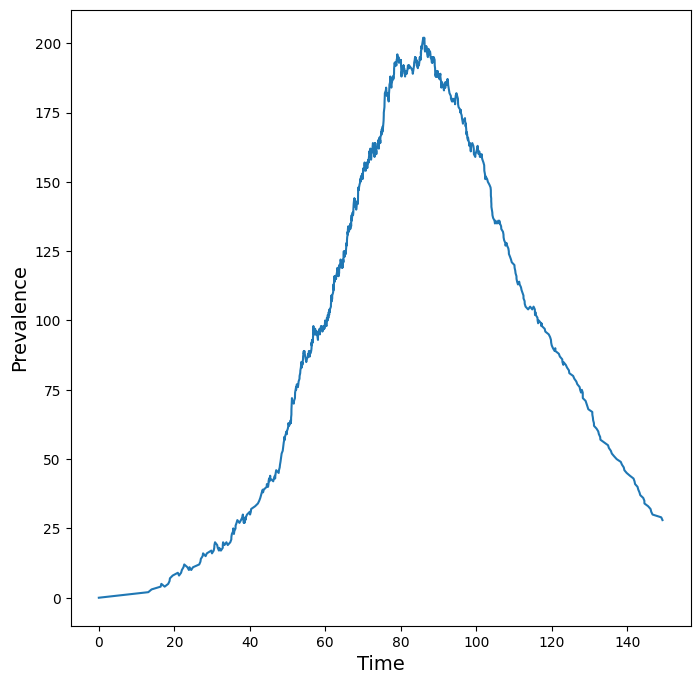

In [26]:
plt.plot(time_record, prevalence_count)
plt.xlabel(r'Time', fontsize=14)
plt.ylabel(r'Prevalence', fontsize=14)


Text(0, 0.5, 'Number of recovered')

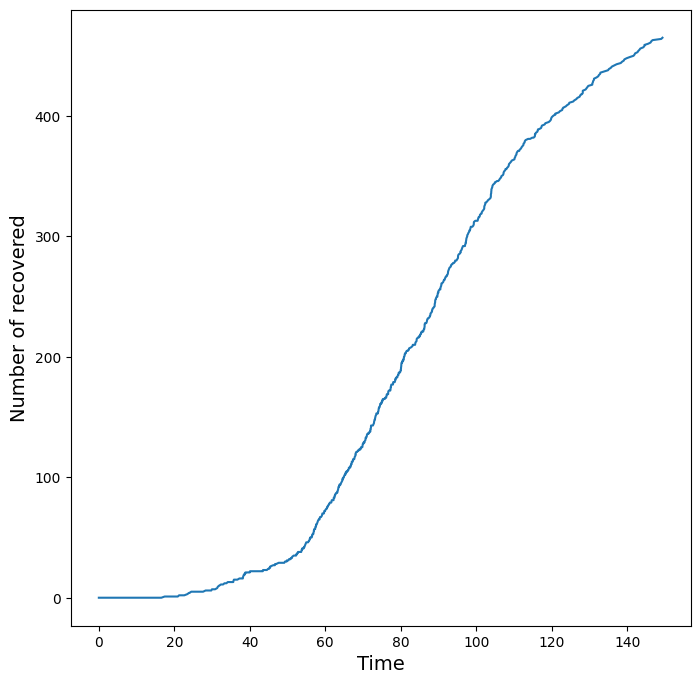

In [27]:
plt.plot(time_record, recovered_count)
plt.xlabel(r'Time', fontsize=14)
plt.ylabel(r'Number of recovered', fontsize=14)

In [28]:
df=pd.DataFrame([time_record,recovered_count])
df.to_csv("/content/drive/My Drive/Network_Tests/recovered_count.csv")
df

,0,1,2,3,4,5,6,7,8,9,...,948,949,950,951,952,953,954,955,956,957
0,0,13.101115,13.982889,16.386216,16.56173,17.444935,18.387247,18.734054,18.840011,19.570818,...,143.478508,144.26089,144.559383,144.579299,145.558851,146.200303,146.385352,146.732818,149.032427,149.358943
1,0,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,...,456.000000,457.00000,458.000000,459.000000,460.000000,461.000000,462.000000,463.000000,464.000000,465.000000
